In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## 1. Data Preparation and Loading

This section handles setting up Kaggle API credentials, downloading the dataset, and extracting its contents. The dataset contains MRI images categorized into four classes related to Alzheimer's disease: ModerateDemented, NonDemented, VeryMildDemented, and MildDemented.

In [ ]:
!kaggle datasets download -d marcopinamonti/alzheimer-mri-4-classes-dataset

Dataset URL: https://www.kaggle.com/datasets/marcopinamonti/alzheimer-mri-4-classes-dataset
License(s): unknown
  0% 0.00/34.1M [00:00<?, ?B/s]
100% 34.1M/34.1M [00:00<00:00, 1.21GB/s]


In [ ]:
!unzip alzheimer-mri-4-classes-dataset.zip

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os
import tqdm
import glob
import tensorflow

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import gray2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
import os
import shutil
import random

SOURCE_DIR = "Alzheimer_MRI_4_classes_dataset"
DEST_DIR = "dataset"

SPLIT = {
    "train": 0.7,
    "val": 0.15,
    "test": 0.15
}

random.seed(42)

# Create destination folders
for split in SPLIT:
    for class_name in os.listdir(SOURCE_DIR):
        os.makedirs(os.path.join(DEST_DIR, split, class_name), exist_ok=True)

# Split images class-wise
for class_name in os.listdir(SOURCE_DIR):
    class_path = os.path.join(SOURCE_DIR, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * SPLIT["train"])
    n_val = int(n_total * SPLIT["val"])

    train_imgs = images[:n_train]
    val_imgs = images[n_train:n_train + n_val]
    test_imgs = images[n_train + n_val:]

    for img in train_imgs:
        shutil.copy(
            os.path.join(class_path, img),
            os.path.join(DEST_DIR, "train", class_name, img)
        )

    for img in val_imgs:
        shutil.copy(
            os.path.join(class_path, img),
            os.path.join(DEST_DIR, "val", class_name, img)
        )

    for img in test_imgs:
        shutil.copy(
            os.path.join(class_path, img),
            os.path.join(DEST_DIR, "test", class_name, img)
        )


In [ ]:
import os
os.listdir("dataset")

['test', 'train', 'val']

In [ ]:
import os
os.listdir("dataset/train")
os.listdir("dataset/val")
os.listdir("dataset/test")

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

## 2. Data Preprocessing and Augmentation

Here, the dataset is split into training, validation, and test sets. ImageDataGenerators are then configured for each set to apply data augmentation techniques (like rotation, zoom, and flips) to the training data and basic rescaling to all sets. This helps in improving the model's generalization capabilities.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

train_dataset = train_datagen.flow_from_directory(
    "dataset/train",
    target_size=(224,224),
    class_mode="categorical",
    batch_size=128
)

# Validation
val_datagen = ImageDataGenerator(rescale=1./255)

valid_dataset = val_datagen.flow_from_directory(
    "dataset/val",
    target_size=(224,224),
    class_mode="categorical",
    batch_size=128,
    shuffle=False
)

# Test
test_datagen = ImageDataGenerator(rescale=1./255)

test_dataset = test_datagen.flow_from_directory(
    "dataset/test",
    target_size=(224,224),
    class_mode="categorical",
    batch_size=128,
    shuffle=False
)


Found 4479 images belonging to 4 classes.
Found 959 images belonging to 4 classes.
Found 962 images belonging to 4 classes.


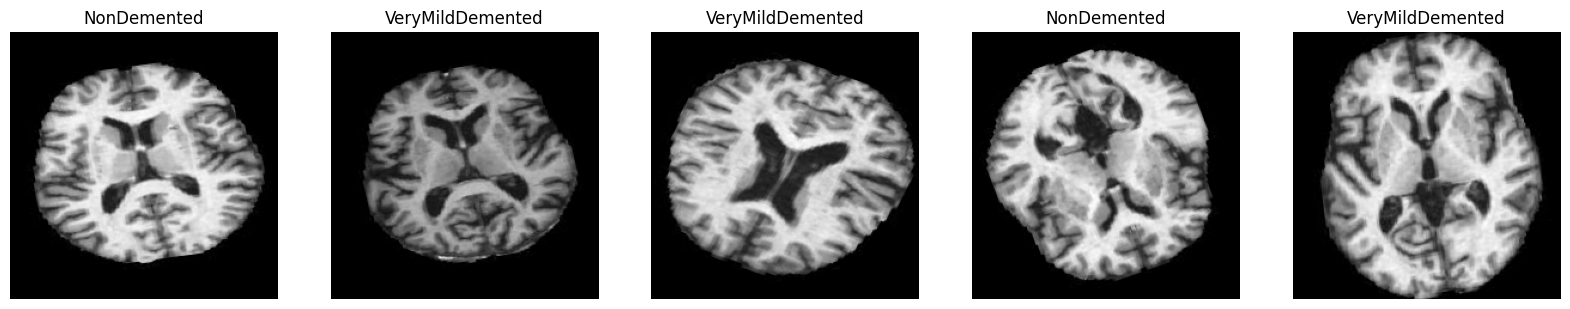

In [ ]:
class_names = train_dataset.class_indices
inv_class_names = {v: k for k, v in class_names.items()}

fig, ax = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(train_dataset.batch_size)

    image = train_dataset[rand1][0][rand2]
    label = train_dataset[rand1][1][rand2]

    ax[i].imshow(image)
    ax[i].axis("off")

    label_index = np.argmax(label)
    ax[i].set_title(inv_class_names[label_index])

## 3. Model Architecture

This section defines the convolutional neural network (CNN) model using a pre-trained DenseNet169 as the base. A custom classification head with dense layers, batch normalization, dropout, and ReLU activation is added on top of the base model. Initially, the base model layers are frozen, and then a subset is unfrozen for fine-tuning.

In [ ]:
# Model Initialization

base_model = DenseNet169(input_shape=(224,224,3),
                         include_top=False,
                         weights="imagenet")

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable=False

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, BatchNormalization,
    GlobalAveragePooling2D, Activation
)
from tensorflow.keras.regularizers import l2

model = Sequential()

# Backbone
model.add(base_model)

# Pooling instead of Flatten
model.add(GlobalAveragePooling2D())

# Classifier head
model.add(Dense(512,
                kernel_initializer="he_uniform",
                kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.4))

model.add(Dense(256,
                kernel_initializer="he_uniform",
                kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.3))

# Output
model.add(Dense(4, activation="softmax"))


In [ ]:
import tensorflow as tf

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

In [ ]:
for layer in base_model.layers[-40:]:
    layer.trainable = True

## 4. Model Training

This section covers the compilation and training of the model. The model uses the Adam optimizer, categorical cross-entropy loss, and tracks accuracy and AUC metrics. Early stopping and model checkpoint callbacks are used to save the best model weights based on validation AUC and prevent overfitting.

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

In [ ]:
# Defining Callbacks

filepath = './best_weights.keras'

earlystopping = EarlyStopping(monitor = 'val_auc',
                              mode = 'max' ,
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_auc',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 50,
                        callbacks = callback_list,
                        verbose = 1)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3517 - auc: 0.6088 - loss: 1.7416
Epoch 1: val_auc improved from -inf to 0.59887, saving model to ./best_weights.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 216s 4s/step - accuracy: 0.3526 - auc: 0.6098 - loss: 1.7387 - val_accuracy: 0.4578 - val_auc: 0.5989 - val_loss: 1.7151
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4546 - auc: 0.7186 - loss: 1.4496
Epoch 2: val_auc improved from 0.59887 to 0.68383, saving model to ./best_weights.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.4553 - auc: 0.7193 - loss: 1.4478 - val_accuracy: 0.5036 - val_auc: 0.6838 - val_loss: 1.3924
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5141 - auc: 0.7778 - loss: 1.2857
Epoch 3: val_auc improved from 0.68383 to 0.76882, saving model to ./best_weights.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.5143 - auc: 0.7781 - loss: 1.2849 - val_accuracy: 0.5151 - val_auc: 0.7688 - val_loss: 1.2470
Epoch 

In [ ]:
import tensorflow as tf

# Load the best weights into the model
model.load_weights("best_weights.keras")

# Save the entire model in the Keras native format
model.save("alzheimer_diagnosis_model.keras")
print("Model saved successfully as alzheimer_diagnosis_model.keras")

Model saved successfully as alzheimer_diagnosis_model.keras


You can also save the model in the TensorFlow SavedModel format which is suitable for deployment with TensorFlow Serving, TensorFlow Lite, TensorFlow.js, or other TensorFlow platforms.

##MODEL EVALUATION

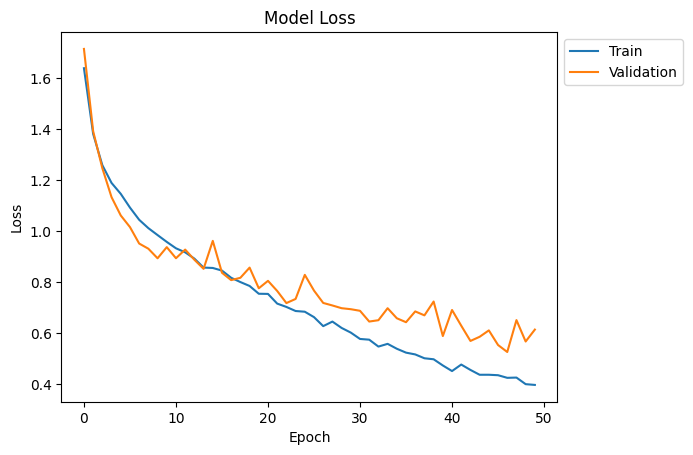

In [ ]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

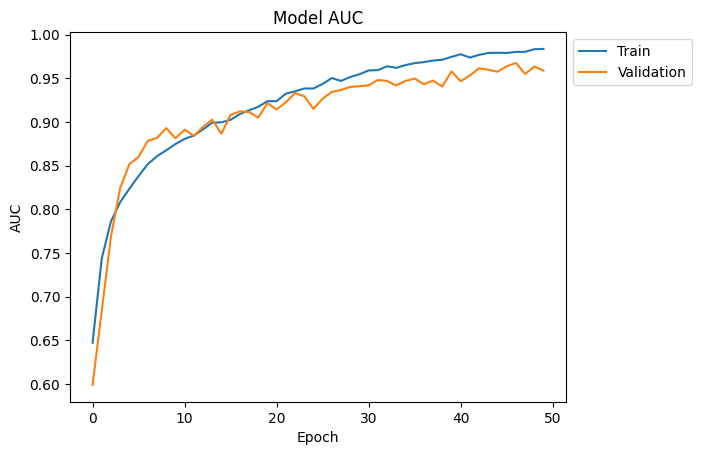

In [ ]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
model.load_weights("best_weights.keras")
# When using ModelCheckpoint with save_best_only=True, loading the saved weights ensures that evaluation is performed on the best-performing model rather than the final training state.


In [ ]:
test_loss, test_accuracy, test_auc = model.evaluate(test_dataset)

print("Test Accuracy:", test_accuracy)
print("Test AUC:", test_auc)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.8195 - auc: 0.9569 - loss: 0.6113
Test Accuracy: 0.8336798548698425
Test AUC: 0.9657385945320129


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
83.36 % chances are there that the image is NonDemented


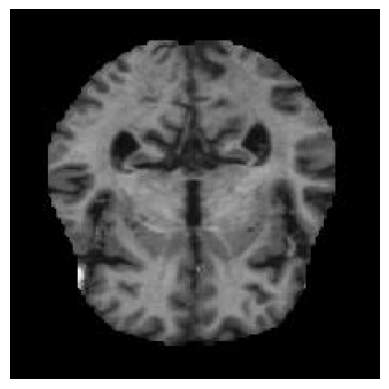

In [ ]:
# Test Case 1: Non-Dementia
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class mapping
dic = test_dataset.class_indices
idc = {v: k for k, v in dic.items()}

# Load image
img_path = "/content/dataset/test/NonDemented/1 (20).jpg"
img = load_img(img_path, target_size=(224,224))
img = img_to_array(img)
img = img / 255.0

# Show image
plt.imshow(img)
plt.axis("off")

# Predict
img = np.expand_dims(img, axis=0)
pred_probs = model.predict(img)
pred_class = np.argmax(pred_probs)
confidence = np.max(pred_probs) * 100

print(round(confidence, 2), "% chances are there that the image is", idc[pred_class])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
90.5 % chances are there that the image is MildDemented


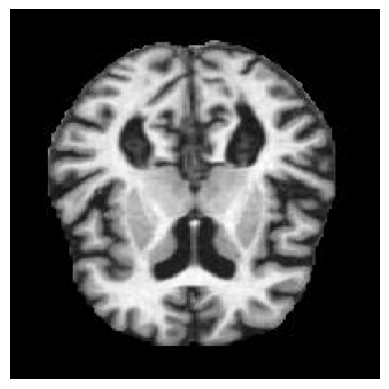

In [ ]:
# Test Case 2: Mild Demented
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class index mapping
dic = test_dataset.class_indices
idc = {v: k for k, v in dic.items()}   # correct inversion

# Load image
img_path = "/content/dataset/test/MildDemented/10 (24).jpg"
img = load_img(img_path, target_size=(224,224))
img = img_to_array(img)
img = img / 255.0

# Display image
plt.imshow(img)
plt.axis("off")

# Prepare for model
img = np.expand_dims(img, axis=0)   # shape: (1, 224, 224, 3)

# Predict
pred_probs = model.predict(img)
pred_class = np.argmax(pred_probs)
confidence = np.max(pred_probs) * 100

# Output
print(
    round(confidence, 2),
    "% chances are there that the image is",
    idc[pred_class]
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
36.4 % chances are there that the image is NonDemented


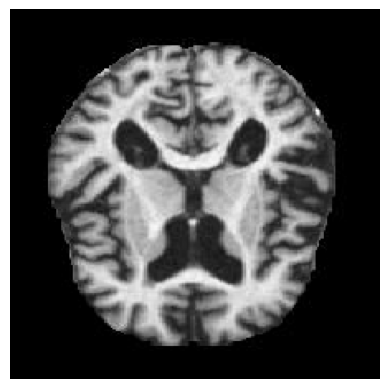

In [ ]:
# Test Case 3: Moderate Demented
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Get class index mapping
dic = test_dataset.class_indices
idc = {v: k for k, v in dic.items()}   # correct inversion

# Load image
img_path = "/content/dataset/test/ModerateDemented/12 (2).jpg"
img = load_img(img_path, target_size=(224,224))
img = img_to_array(img)
img = img / 255.0

# Show image
plt.imshow(img)
plt.axis("off")

# Prepare for prediction
img = np.expand_dims(img, axis=0)   # (1, 224, 224, 3)

# Predict
pred_probs = model.predict(img)
pred_class = np.argmax(pred_probs)
confidence = np.max(pred_probs) * 100

# Print result
print(
    round(confidence, 2),
    "% chances are there that the image is",
    idc[pred_class]
)


**The Moderate Demented class contains MRI slices from only two subjects, which limits the model’s ability to generalize. As a result, predictions for this class show lower confidence and occasional misclassification, highlighting a key dataset limitation rather than a modeling flaw**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
82.88 % chances are there that the image is VeryMildDemented


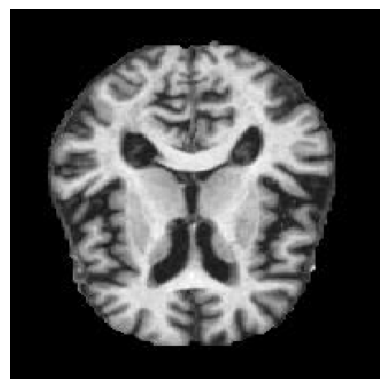

In [ ]:
# Test Case 4: Very Mild Demented

from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Get class index mapping from generator
dic = test_dataset.class_indices
idc = {v: k for k, v in dic.items()}   # correct inversion

# Load image (Very Mild Demented)
img_path = "/content/dataset/test/VeryMildDemented/11 (21).jpg"
img = load_img(img_path, target_size=(224,224))
img = img_to_array(img)
img = img / 255.0

# Display image
plt.imshow(img)
plt.axis("off")

# Prepare for prediction (add batch dimension)
img = np.expand_dims(img, axis=0)   # shape: (1, 224, 224, 3)

# Predict
pred_probs = model.predict(img)
pred_class = np.argmax(pred_probs)
confidence = np.max(pred_probs) * 100

# Output result
print(
    round(confidence, 2),
    "% chances are there that the image is",
    idc[pred_class]
)


#**Inference and Key Findings**

**1.** **Model convergence and generalization**

The model demonstrates stable convergence in the final training phase. Across the last five epochs, the training AUC and validation AUC remain closely aligned, indicating that the model has learned meaningful features without significant overfitting. Validation AUC peaked at 0.9675, while training AUC remained around 0.98, reflecting a healthy bias–variance balance.

The absence of a widening gap between training and validation metrics suggests that the applied regularization techniques (data augmentation, Global Average Pooling, dropout, and partial fine-tuning) were effective in controlling overfitting.

**2. Validation and test performance consistency**

Final evaluation on the held-out test dataset yielded:

Test Accuracy: 83.37%

Test AUC: 96.57%

The test AUC closely matches the best validation AUC, confirming that the model generalizes well to unseen data. This consistency indicates that the training process did not leak validation information and that the model’s performance is not inflated by overfitting.

Given the class imbalance and medical nature of the dataset, AUC is considered the most reliable performance metric, as it evaluates class separability independent of decision thresholds.

**3. Single-image inference behavior**

Qualitative evaluation on individual MRI slices shows the following behavior:

Non-Demented: Correctly classified with high confidence (83.36%)

Very Mild Demented: Correctly classified with high confidence (82.88%)

Mild Demented: Correctly classified with very high confidence (90.5%)

Moderate Demented: Misclassified as Non-Demented with low confidence (36.4%)

The model performs reliably for Non-Demented, Very Mild, and Mild Demented classes, indicating strong learning of structural brain patterns associated with early and mild stages of cognitive decline.

**4. Interpretation of Moderate Demented misclassification**

The misclassification of the Moderate Demented case is consistent with a known dataset limitation. The Moderate Demented class contains MRI slices from only two subjects, which severely restricts the model’s ability to learn generalizable features for this class.

The low confidence (36.4%) is an important signal: rather than making an overconfident incorrect prediction, the model expresses uncertainty, which is a desirable behavior in medical AI systems. This outcome reflects data scarcity rather than a modeling or implementation error.

**5. Domain-aware interpretation**

From a clinical and machine-learning perspective:

MRI-based dementia classification benefits from structural pattern recognition, which the model captures effectively for well-represented classes.

Subject-level imbalance significantly impacts advanced dementia stages, emphasizing the importance of dataset composition in medical deep learning.

The model is better suited for early-stage detection (Non-Demented vs Demented progression) than for fine-grained separation of advanced stages.

#**6. Overall conclusion**

The proposed DenseNet169-based transfer learning approach achieves strong discriminative performance on Alzheimer’s MRI classification, with robust generalization as evidenced by high and consistent validation and test AUC scores.

While performance for the Moderate Demented class is limited by extreme subject imbalance, the model’s behavior remains clinically reasonable and transparent. These findings highlight both the effectiveness of deep learning for early dementia detection and the critical role of dataset quality in medical AI syste